In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
train_data = pd.read_excel(r'D:\ML Projects\Propensify\train.xlsx')
test_data = pd.read_excel(r'D:\ML Projects\Propensify\test.xlsx')

In [3]:
def clean_data(data, columns_to_fill):
    print("Missing values before cleaning:\n", data.isnull().sum())
    for column in columns_to_fill:
        if column in data.columns:
            if data[column].dtype == 'object':
                data[column] = data[column].fillna(data[column].mode()[0])
            else:
                data[column] = data[column].fillna(data[column].mean())
    data = data.dropna()
    print("Missing values after cleaning:\n", data.isnull().sum())
    return data

In [11]:
columns_to_fill = ['custAge', 'schooling', 'day_of_week', 'profit']

In [13]:
train_data = clean_data(train_data, columns_to_fill)
test_data = clean_data(test_data, columns_to_fill)

Missing values before cleaning:
 custAge           2016
profession           2
marital              2
schooling         2408
default              2
housing              2
loan                 2
contact              2
month                2
day_of_week        789
campaign             2
pdays                2
previous             2
poutcome             2
emp.var.rate         2
cons.price.idx       2
cons.conf.idx        2
euribor3m            2
nr.employed          2
pmonths              2
pastEmail            2
responded            2
profit            7310
id                   2
dtype: int64
Missing values after cleaning:
 custAge           0
profession        0
marital           0
schooling         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employe

In [15]:
def perform_eda(data):
    plt.figure(figsize=(8, 6))
    sns.countplot(x='responded', data=data)
    plt.title('Distribution of Target Variable')
    plt.show()
    plt.figure(figsize=(12, 10))
    numeric_cols = data.select_dtypes(include='number').columns
    corr = data[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

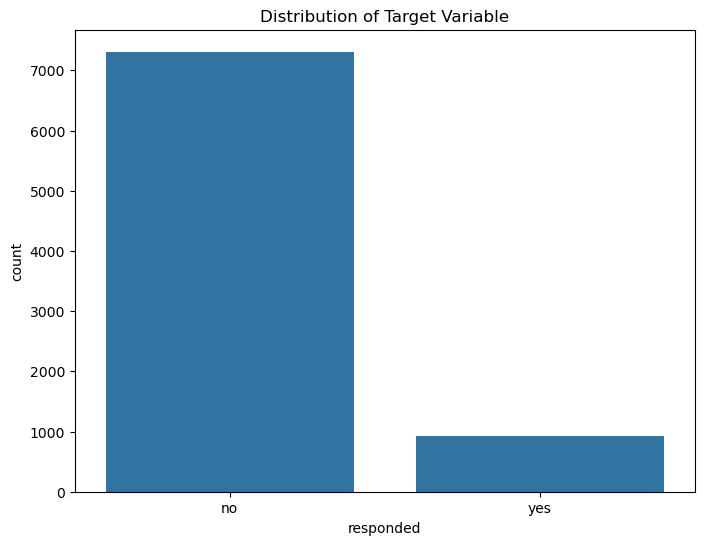

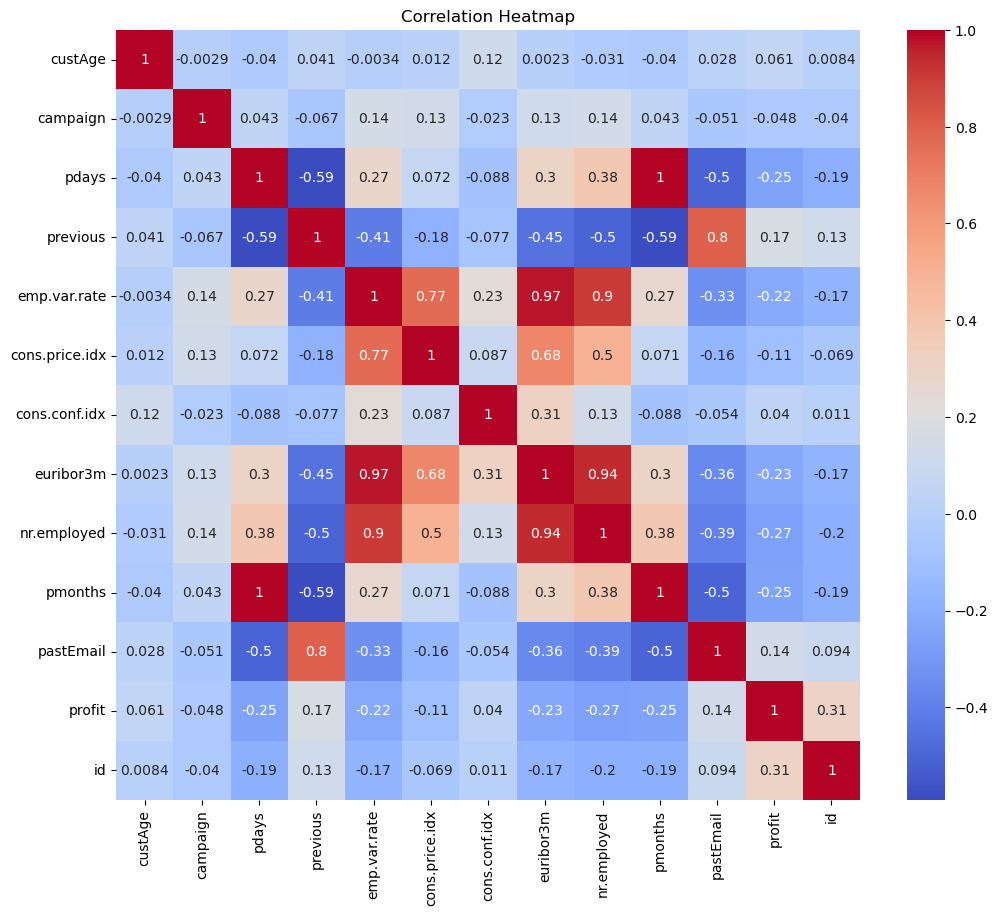

In [17]:
perform_eda(train_data)

In [19]:
def feature_engineering(data):
    categorical_features = ['profession', 'marital', 'schooling', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    existing_categorical_features = [col for col in categorical_features if col in data.columns]
    data = pd.get_dummies(data, columns=existing_categorical_features)
    return data

In [21]:
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

In [23]:
feature_names = train_data.columns.tolist()
with open('feature_names.pkl', 'wb') as f:
    joblib.dump(feature_names, f)

In [25]:
X = train_data.drop(['responded', 'id'], axis=1)
y = train_data['responded'].map({'yes': 1, 'no': 0})
X_test = test_data.drop(['responded', 'id'], axis=1, errors='ignore')

In [27]:
def handle_imbalance(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [29]:
X_resampled, y_resampled = handle_imbalance(X, y)

In [31]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

In [33]:
X_resampled_scaled, X_test_scaled, scaler = scale_data(X_resampled, X_test)

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

In [37]:
def train_and_evaluate_models(X_train, y_train, X_val, y_val):
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
    }
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        print(f"{name} - Classification Report")
        print(classification_report(y_val, y_pred))
        print(f"{name} - ROC-AUC Score: {roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])}")
        print()

In [39]:
train_and_evaluate_models(X_train, y_train, X_val, y_val)

Random Forest - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1481
           1       1.00      1.00      1.00      1443

    accuracy                           1.00      2924
   macro avg       1.00      1.00      1.00      2924
weighted avg       1.00      1.00      1.00      2924

Random Forest - ROC-AUC Score: 0.9999971924347346



In [43]:
Propensify_model = RandomForestClassifier(random_state=42)
Propensify_model.fit(X_resampled_scaled, y_resampled)

RandomForestClassifier(random_state=42)

In [45]:
joblib.dump(Propensify_model, 'Propensify_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [47]:
test_predictions = Propensify_model.predict(X_test_scaled)

In [49]:
output = pd.DataFrame({'CustomerID': test_data['id'], 'Response': test_predictions})
output.to_csv(r'D:\ML Projects\test_predictions.csv', index=False)